## # 프로젝트 개요
#### # 오늘 내가 해볼 것
- EDA
- Regression 모델 몇 개 선정
- Regression 모델별 하이퍼파라미터 탐색(Grid Search) - _실패_
- Regression 모델별 하이퍼파라미터 탐색(Random Search) - _실패_
- 해당 모델들로 블렌딩

#### # 데이터 불러오기

In [1]:
# 패키지

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
%config matplotlib.figure_format='retina'

from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold, cross_val_score
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

In [2]:
data_path = os.getenv("HOME") + '/aiffel/kaggle_kakr_housing/data'
train_path = os.path.join(data_path, 'train.csv')
test_path = os.path.join(data_path, 'test.csv')

df_train = pd.read_csv(train_path)
df_test = pd.read_csv(test_path)
print(f'df_train shape: {df_train.shape}')
print(f'df_test shape: {df_test.shape}')

df_train shape: (15035, 21)
df_test shape: (6468, 20)


#### Data Description

01) ID : 집을 구분하는 번호  
02) date : 집을 구매한 날짜  
03) price : 집의 가격(Target variable)  
04) bedrooms : 침실의 수  
05) bathrooms : 화장실의 수  
06) sqft_living : 주거 공간의 평방 피트(면적)  
07) sqft_lot : 부지의 평방 피트(면적)  
08) floors : 집의 층 수  
09) waterfront : 집의 전방에 강이 흐르는지 유무 (a.k.a. 리버뷰)  
10) view : 집이 얼마나 좋아 보이는지의 정도  
11) condition : 집의 전반적인 상태  
12) grade : King County grading 시스템 기준으로 매긴 집의 등급  
13) sqft_above : 지하실을 제외한 평방 피트(면적)  
14) sqft_basement : 지하실의 평방 피트(면적)  
15) yr_built : 지어진 년도  
16) yr_renovated : 집을 재건축한 년도  
17) zipcode : 우편번호  
18) lat : 위도  
19) long : 경도  
20) sqft_living15 : 2015년 기준 주거 공간의 평방 피트(면적, 집을 재건축했다면, 변화가 있을 수 있음)  
21) sqft_lot15 : 2015년 기준 부지의 평방 피트(면적, 집을 재건축했다면, 변화가 있을 수 있음)  

#### # EDA
- 결측치 확인
- 컬럼별 분포 visualisation
- 라벨 할당
  - log 변환
- train EDA
  - 필요 없는 것 삭제
- test에 같이 적용

In [3]:
df_train.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,1,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,2,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,3,20140627T000000,257500.0,3,2.25,1715,6819,2.0,0,0,...,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,4,20150115T000000,291850.0,3,1.50,1060,9711,1.0,0,0,...,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


In [4]:
# 결측치 확인
df_train.isnull().sum()

id               0
date             0
price            0
bedrooms         0
bathrooms        0
sqft_living      0
sqft_lot         0
floors           0
waterfront       0
view             0
condition        0
grade            0
sqft_above       0
sqft_basement    0
yr_built         0
yr_renovated     0
zipcode          0
lat              0
long             0
sqft_living15    0
sqft_lot15       0
dtype: int64

In [5]:
df_test.isnull().sum()

id               0
date             0
bedrooms         0
bathrooms        0
sqft_living      0
sqft_lot         0
floors           0
waterfront       0
view             0
condition        0
grade            0
sqft_above       0
sqft_basement    0
yr_built         0
yr_renovated     0
zipcode          0
lat              0
long             0
sqft_living15    0
sqft_lot15       0
dtype: int64

In [6]:
# 타겟 데이터 train에서 제거
y_train = df_train['price']
df_train = df_train.drop(columns= 'price', axis=1)
df_train.head()

,id,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,20141013T000000,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,1,20150225T000000,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,2,20150218T000000,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,3,20140627T000000,3,2.25,1715,6819,2.0,0,0,3,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,4,20150115T000000,3,1.50,1060,9711,1.0,0,0,3,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


In [7]:
# 데이터 타입 확인
df_train.dtypes

id                 int64
date              object
bedrooms           int64
bathrooms        float64
sqft_living        int64
sqft_lot           int64
floors           float64
waterfront         int64
view               int64
condition          int64
grade              int64
sqft_above         int64
sqft_basement      int64
yr_built           int64
yr_renovated       int64
zipcode            int64
lat              float64
long             float64
sqft_living15      int64
sqft_lot15         int64
dtype: object

In [8]:
# id 삭제 train, test 둘 다 삭제
df_train.drop(columns='id', axis=1, inplace=True)
df_test.drop(columns='id', axis=1, inplace=True)

print(df_train.columns)
print(df_test.columns)

Index(['date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')
Index(['date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')


In [9]:
# date 컬럼 변환
df_train['date'] = df_train['date'].apply(lambda x: x[:6]).astype(int)
df_test['date'] = df_test['date'].apply(lambda x: x[:6]).astype(int)

In [10]:
df_train.head()

,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,201410,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,201502,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,201502,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,201406,3,2.25,1715,6819,2.0,0,0,3,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,201501,3,1.50,1060,9711,1.0,0,0,3,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


##### Visualisation

In [11]:
columns = df_train.columns
len(columns)    

19

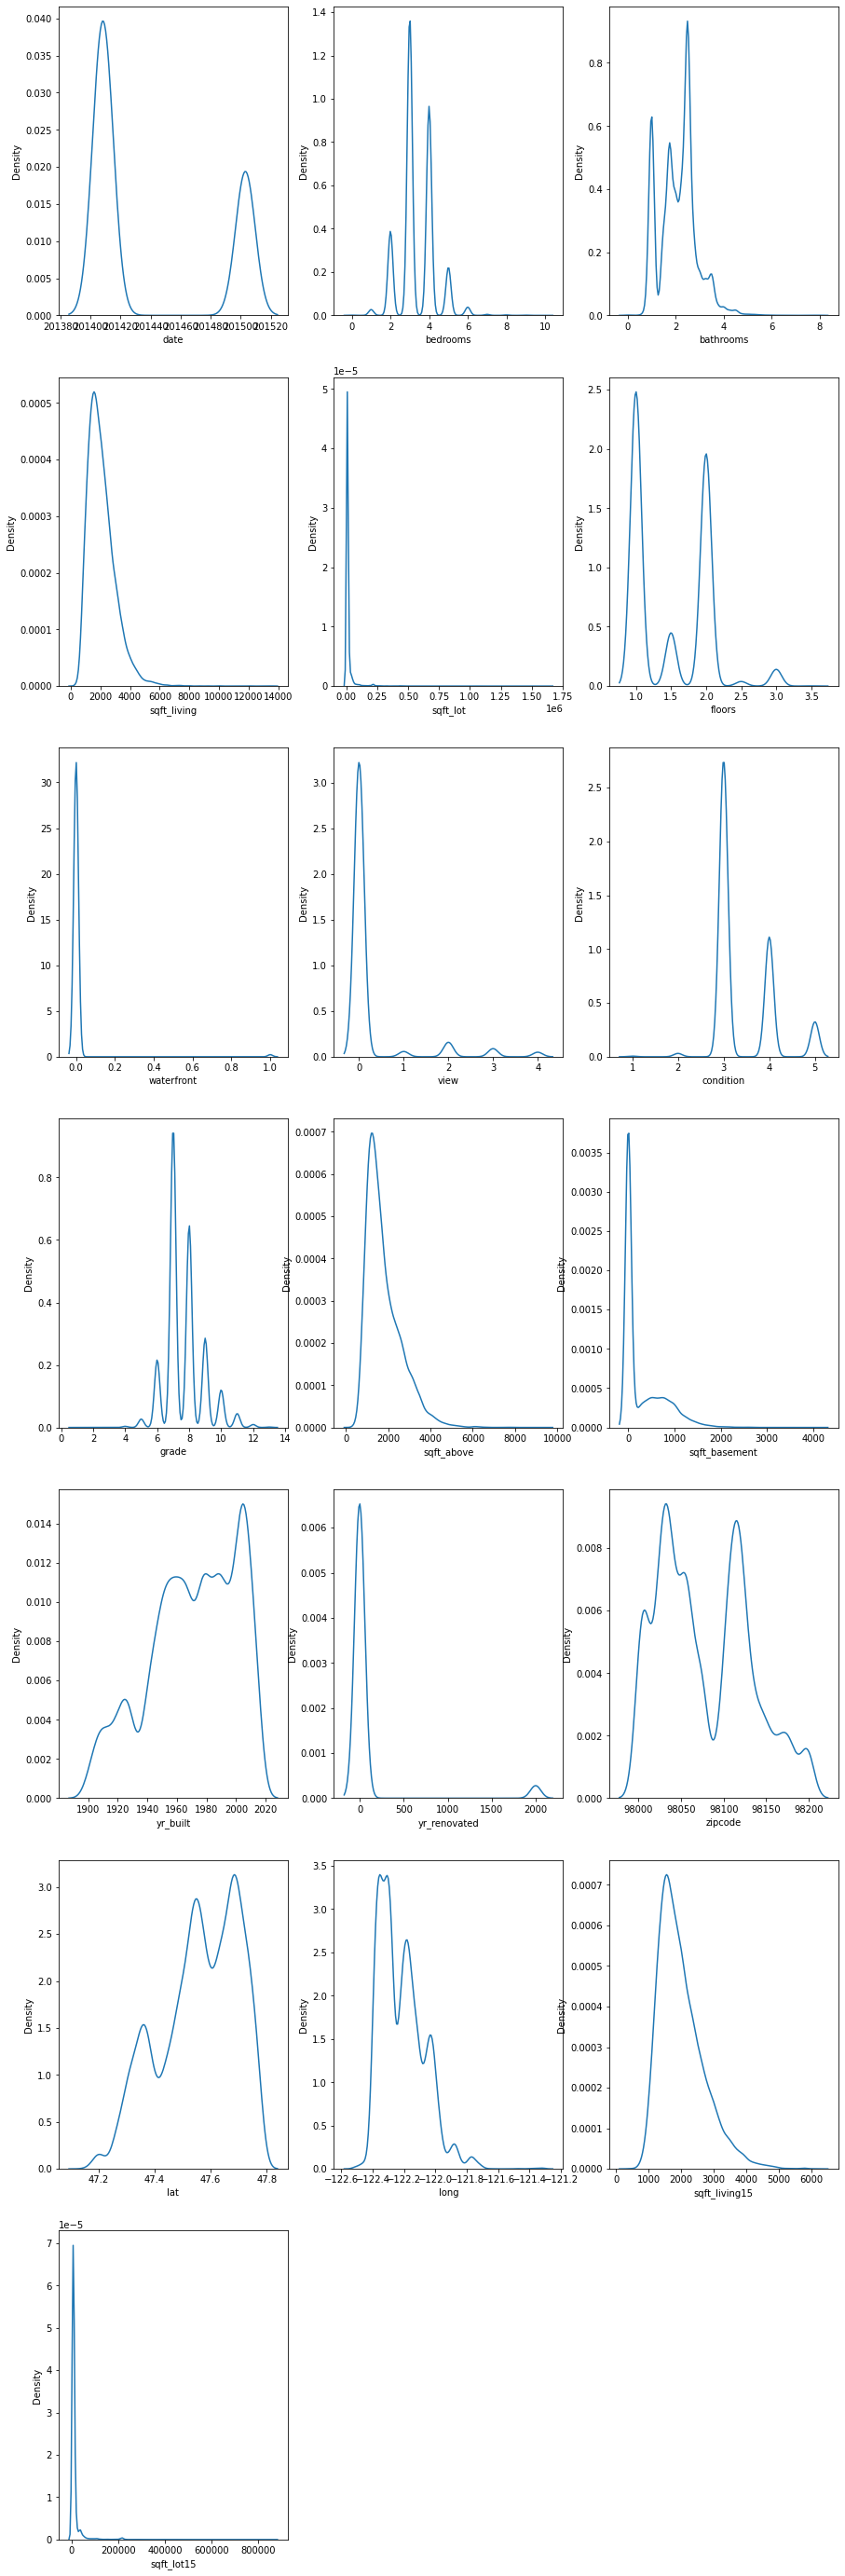

In [12]:
plt.figure(figsize=(15, 50))
for idx, col in enumerate(columns):
    plt.subplot(7, 3, idx+1)
    sns.kdeplot(df_train[col])
    if idx == 20:
        break

plt.show()

#### 느낀 점
> - 집을 구매한 날짜도 그렇게 오래되지 않았다.  
> - skewness 치우친 것들 중 waterfront는 boolean 값이어서 log 변환을 안 해줘도 된다.
> - sqft_basement, yr_renovated, view, waterfront 는 0이 많은데, 다 의미 있는 것 같아서 어떻게 처리하면 좋을지 궁금하다.
> - 이들의 price의 상관 관계가 궁금하다
> - skewness가 치우친 것들은 log 변환을 해준다

In [13]:
# skew_columns 할당
# 난 bathrooms도 log 변환으로 의미 있는 영향을 끼칠 수 있을 것 같아서추가했다.
skew_columns = ['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement', 'sqft_lot15', 'sqft_living15']

for col in skew_columns:
    df_train[col] = np.log1p(df_train[col])

df_train.head()

,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,201410,1.386294,0.693147,7.074117,8.639588,1.0,0,0,3,7,7.074117,0.0,1955,0,98178,47.5112,-122.257,7.201171,8.639588
1,201502,1.098612,0.693147,6.647688,9.210440,1.0,0,0,3,6,6.647688,0.0,1933,0,98028,47.7379,-122.233,7.908755,8.995041
2,201502,1.386294,1.098612,7.427144,8.997271,1.0,0,0,3,8,7.427144,0.0,1987,0,98074,47.6168,-122.045,7.496097,8.923191
3,201406,1.386294,1.178655,7.447751,8.827615,2.0,0,0,3,7,7.447751,0.0,1995,0,98003,47.3097,-122.327,7.713785,8.827615
4,201501,1.386294,0.916291,6.966967,9.181118,1.0,0,0,3,7,6.966967,0.0,1963,0,98198,47.4095,-122.315,7.409136,9.181118


In [14]:
# test 셋도 동일하게 적용

for col in skew_columns:
    df_test[col] = np.log1p(df_test[col])
    
df_test.head()

,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,201412,1.386294,1.178655,7.852050,8.887791,2.0,0,0,3,7,7.682943,5.993961,1951,1991,98125,47.7210,-122.319,7.433075,8.941153
1,201412,1.609438,1.386294,7.581210,8.517393,1.0,0,0,5,7,6.957497,6.814543,1965,0,98136,47.5208,-122.393,7.215975,8.517393
2,201405,1.609438,1.704748,8.598036,11.532051,1.0,0,0,3,11,8.266421,7.333676,2001,0,98053,47.6561,-122.005,8.468213,11.532051
3,201504,1.386294,0.693147,7.484930,8.918784,1.0,0,0,3,7,6.957497,6.594413,1960,0,98146,47.5123,-122.337,7.484930,9.001346
4,201503,1.386294,1.252763,7.544861,8.788898,2.0,0,0,3,7,7.544861,0.000000,2003,0,98038,47.3684,-122.031,7.779467,8.932080


In [15]:
# 추후 사용할 기본적인 전처리만 끝난 데이터셋 확보
df_train_original = df_train.copy()
df_test_original = df_test.copy()

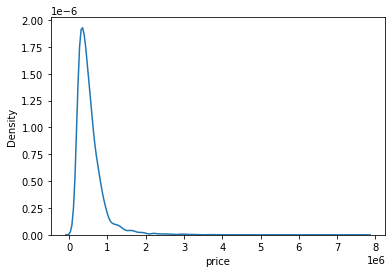

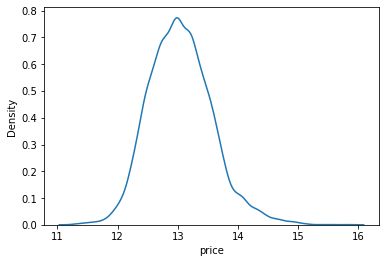

In [16]:
# y값의 분포 확인 및 log 변환

sns.kdeplot(y_train)
plt.show()

y_train = np.log1p(y_train)

# 재확인
sns.kdeplot(y_train)
plt.show()


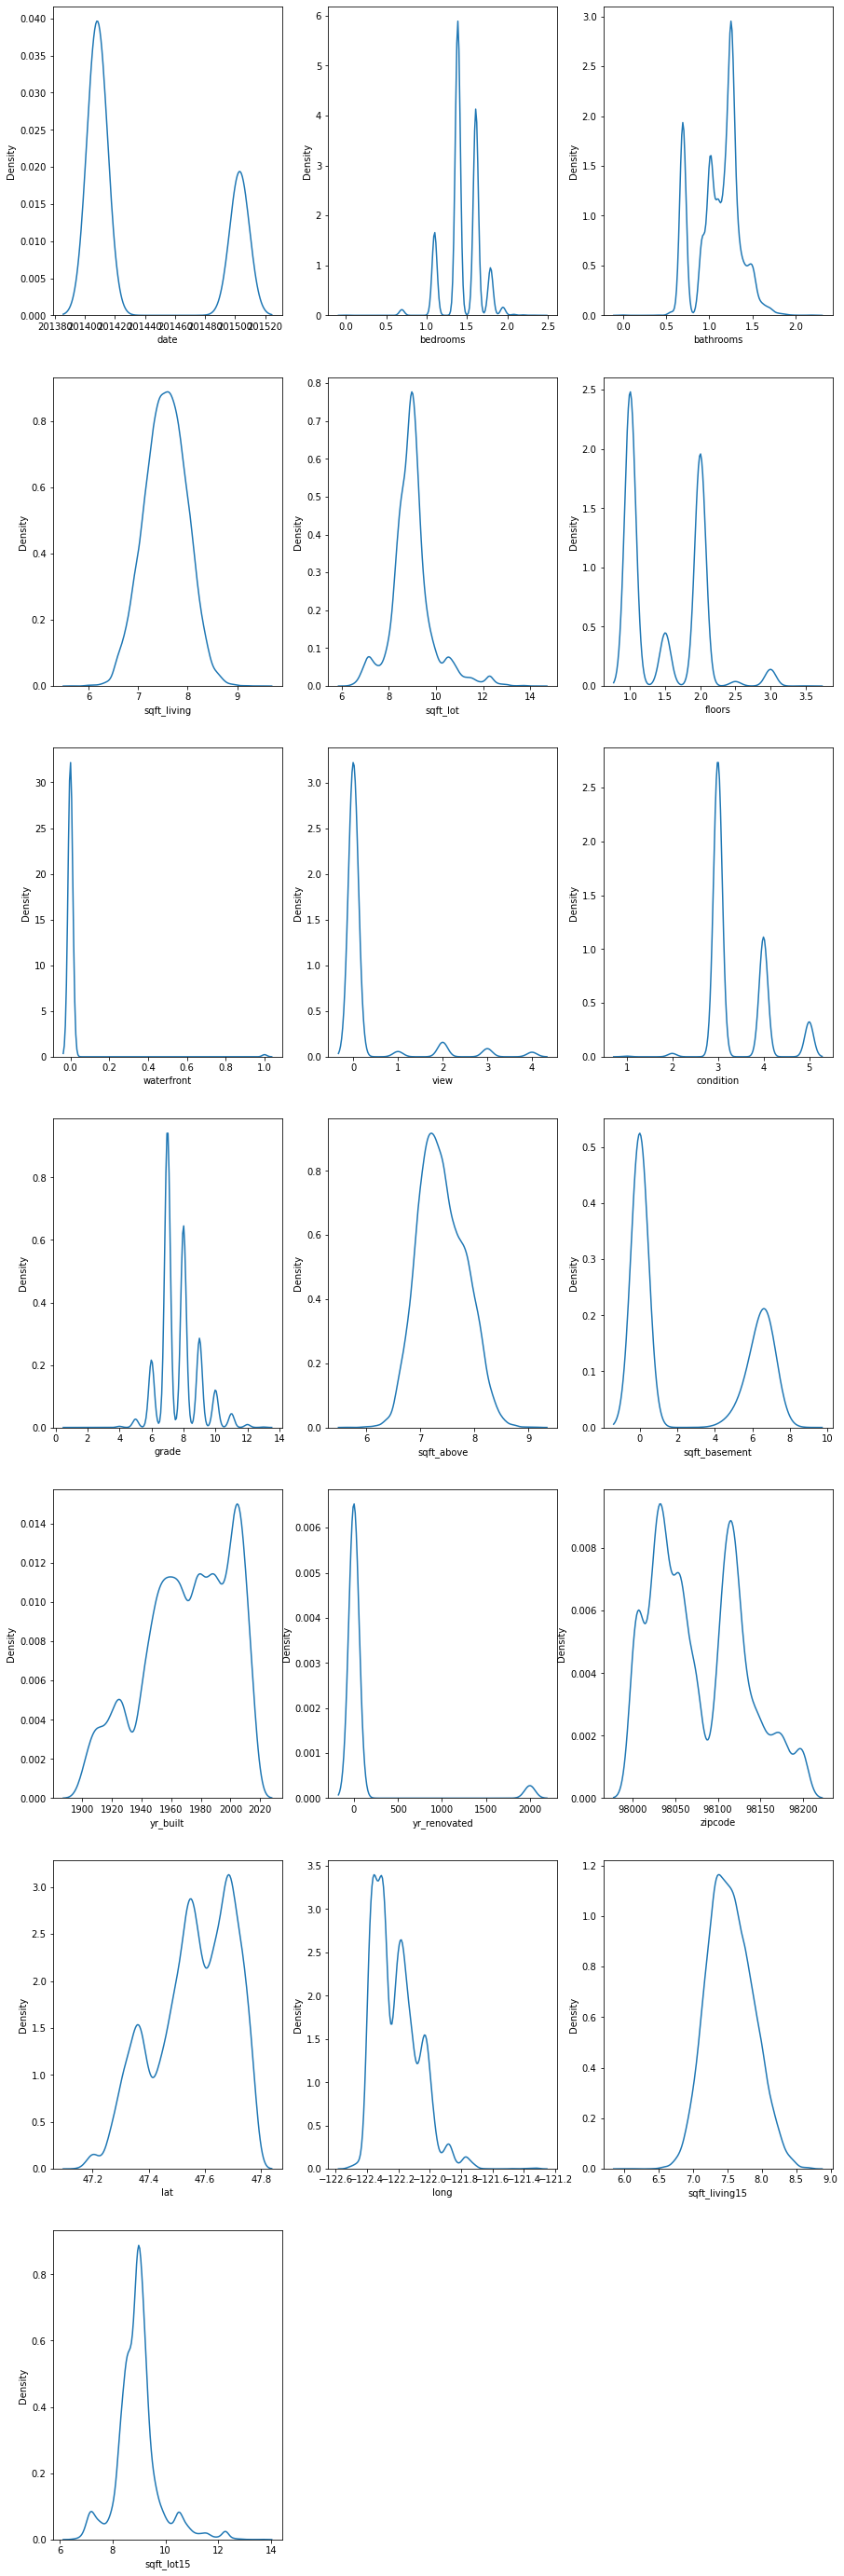

In [17]:
# skewness 다시 확인
plt.figure(figsize=(15, 50))
for idx, col in enumerate(columns):
    plt.subplot(7, 3, idx+1)
    sns.kdeplot(df_train[col])
    if idx == 20:
        break

plt.show()

> yr_renovated 컬럼이 대체로 boolean 값으로 만들 수 있을 것 같아서 확인 후 맞으면 컬럼 내 스케일이 좁은 boolean 값으로 만들어 줄 예정이다.

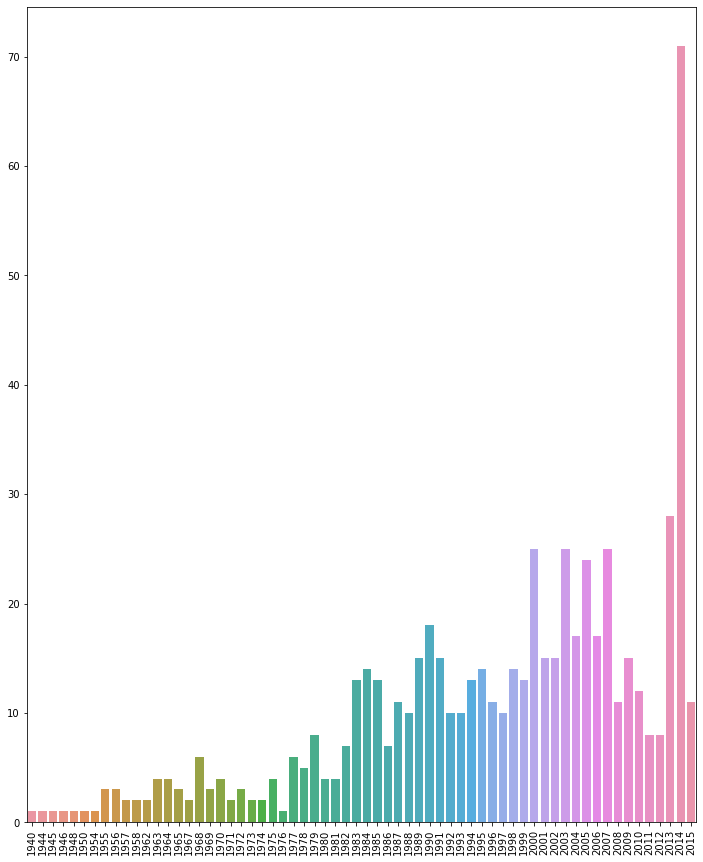

In [18]:
# yr_renovated에서 0값을 빼고 renovated 된 것들만의 분포 확인
renovated_years = df_train['yr_renovated'].value_counts()[1:] # 첫번째 값이 0값의 갯수여서 제외함

plt.figure(figsize=(12, 15))
plt.subplot(1,1,1)
sns.barplot(x=renovated_years.index, y=renovated_years.values)
plt.xticks(rotation=90)
plt.show()

> yr_renovated 컬럼은 값이 0 이상인(즉, renovated 된) 행들 중 연식별로 값을 다르게 줄 예정
> - 1940 ~ 1980 = 0.5
> - 1981 ~ 1990 = 1
> - 1991 ~ 2000 = 1.5
> - 2001 ~ 2010 = 2
> - 2011 ~ 2020 = 2.5

In [19]:
# 새로운 컬럼 생성
df_train['new_renovated'] = df_train['yr_renovated'].copy()

In [20]:
df_train.head()

,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,new_renovated
0,201410,1.386294,0.693147,7.074117,8.639588,1.0,0,0,3,7,7.074117,0.0,1955,0,98178,47.5112,-122.257,7.201171,8.639588,0
1,201502,1.098612,0.693147,6.647688,9.210440,1.0,0,0,3,6,6.647688,0.0,1933,0,98028,47.7379,-122.233,7.908755,8.995041,0
2,201502,1.386294,1.098612,7.427144,8.997271,1.0,0,0,3,8,7.427144,0.0,1987,0,98074,47.6168,-122.045,7.496097,8.923191,0
3,201406,1.386294,1.178655,7.447751,8.827615,2.0,0,0,3,7,7.447751,0.0,1995,0,98003,47.3097,-122.327,7.713785,8.827615,0
4,201501,1.386294,0.916291,6.966967,9.181118,1.0,0,0,3,7,6.966967,0.0,1963,0,98198,47.4095,-122.315,7.409136,9.181118,0


In [21]:
# mask 조건 할당
mask1 = (df_train['yr_renovated'] > 0) & (df_train['yr_renovated'] > 1939) & (df_train['yr_renovated'] <= 1980)
mask2 = (df_train['yr_renovated'] > 0) & (df_train['yr_renovated'] > 1981) & (df_train['yr_renovated'] <= 1990)
mask3 = (df_train['yr_renovated'] > 0) & (df_train['yr_renovated'] > 1991) & (df_train['yr_renovated'] <= 2000)
mask4 = (df_train['yr_renovated'] > 0) & (df_train['yr_renovated'] > 2001) & (df_train['yr_renovated'] <= 2010)
mask5 = (df_train['yr_renovated'] > 0) & (df_train['yr_renovated'] > 2011) & (df_train['yr_renovated'] <= 2020)

# 년도에 float형태로 적힌 것들 마스크 조건 할당
sp_mask1 = (df_train['yr_renovated'] == 1991.0)
sp_mask2 = (df_train['yr_renovated'] == 2001.0)
sp_mask3 = (df_train['yr_renovated'] == 2011.0)
sp_mask4 = (df_train['yr_renovated'] == 1981.0)

In [22]:
# 값 변경
df_train.loc[mask1, 'new_renovated'] = df_train.loc[mask1, 'new_renovated'].apply(lambda x: 0.5)
df_train.loc[mask2, 'new_renovated'] = df_train.loc[mask2, 'new_renovated'].apply(lambda x: 1.0)
df_train.loc[mask3, 'new_renovated'] = df_train.loc[mask3, 'new_renovated'].apply(lambda x: 1.5)
df_train.loc[mask4, 'new_renovated'] = df_train.loc[mask4, 'new_renovated'].apply(lambda x: 2.0)
df_train.loc[mask5, 'new_renovated'] = df_train.loc[mask5, 'new_renovated'].apply(lambda x: 2.5)

# float 형태여서 뭔가 잘 안 바뀌는 것들도 manully 변경
df_train.loc[sp_mask1, 'new_renovated'] = df_train.loc[sp_mask1, 'new_renovated'].apply(lambda x: 1.5)
df_train.loc[sp_mask2, 'new_renovated'] = df_train.loc[sp_mask2, 'new_renovated'].apply(lambda x: 2.0)
df_train.loc[sp_mask3, 'new_renovated'] = df_train.loc[sp_mask3, 'new_renovated'].apply(lambda x: 2.5)
df_train.loc[sp_mask4, 'new_renovated'] = df_train.loc[sp_mask4, 'new_renovated'].apply(lambda x: 0.5)

In [23]:
# 확인
df_train['new_renovated'].value_counts()

0.0    14404
2.0      176
1.5      135
2.5      126
1.0      108
0.5       86
Name: new_renovated, dtype: int64

In [24]:
# test 셋에도 동일하게 적용

# 새로운 컬럼 생성
df_test['new_renovated'] = df_test['yr_renovated'].copy()

# mask 조건 할당
tmask1 = (df_test['yr_renovated'] > 0) & (df_test['yr_renovated'] > 1939) & (df_test['yr_renovated'] <= 1980)
tmask2 = (df_test['yr_renovated'] > 0) & (df_test['yr_renovated'] > 1981) & (df_test['yr_renovated'] <= 1990)
tmask3 = (df_test['yr_renovated'] > 0) & (df_test['yr_renovated'] > 1991) & (df_test['yr_renovated'] <= 2000)
tmask4 = (df_test['yr_renovated'] > 0) & (df_test['yr_renovated'] > 2001) & (df_test['yr_renovated'] <= 2010)
tmask5 = (df_test['yr_renovated'] > 0) & (df_test['yr_renovated'] > 2011) & (df_test['yr_renovated'] <= 2020)

# 년도에 float형태로 적힌 것들 마스크 조건 할당
tsp_mask1 = (df_test['yr_renovated'] == 1991.0)
tsp_mask2 = (df_test['yr_renovated'] == 2001.0)
tsp_mask3 = (df_test['yr_renovated'] == 2011.0)
tsp_mask4 = (df_test['yr_renovated'] == 1981.0)
tsp_mask5 = (df_test['yr_renovated'] == 1934.0)


# 값 변경
df_test.loc[tmask1, 'new_renovated'] = df_test.loc[tmask1, 'new_renovated'].apply(lambda x: 0.5)
df_test.loc[tmask2, 'new_renovated'] = df_test.loc[tmask2, 'new_renovated'].apply(lambda x: 1.0)
df_test.loc[tmask3, 'new_renovated'] = df_test.loc[tmask3, 'new_renovated'].apply(lambda x: 1.5)
df_test.loc[tmask4, 'new_renovated'] = df_test.loc[tmask4, 'new_renovated'].apply(lambda x: 2.0)
df_test.loc[tmask5, 'new_renovated'] = df_test.loc[tmask5, 'new_renovated'].apply(lambda x: 2.5)

# float 형태여서 뭔가 잘 안 바뀌는 것들도 manully 변경
df_test.loc[tsp_mask1, 'new_renovated'] = df_test.loc[tsp_mask1, 'new_renovated'].apply(lambda x: 1.5)
df_test.loc[tsp_mask2, 'new_renovated'] = df_test.loc[tsp_mask2, 'new_renovated'].apply(lambda x: 2.0)
df_test.loc[tsp_mask3, 'new_renovated'] = df_test.loc[tsp_mask3, 'new_renovated'].apply(lambda x: 2.5)
df_test.loc[tsp_mask4, 'new_renovated'] = df_test.loc[tsp_mask4, 'new_renovated'].apply(lambda x: 0.5)
df_test.loc[tsp_mask5, 'new_renovated'] = df_test.loc[tsp_mask5, 'new_renovated'].apply(lambda x: 0.0)


# 확인
df_test['new_renovated'].value_counts()

0.0    6187
2.0      79
1.5      57
1.0      53
0.5      50
2.5      42
Name: new_renovated, dtype: int64

> long 값을 양의 정수로 바꿔서 scaling하면 좋을 것 같다.

In [25]:
print('min long:', min(df_train['long'].value_counts().index))
print('max long:', max(df_train['long'].value_counts().index))

min long: -122.519
max long: -121.315


> 범위를 구했는데 -122 ~ -121 정도 사이여서 모든 값에 -1*min 값을 더해서 0˜1사이의 수로 만들겠다.
> - apply() 쓰려다 너무 느려서 그냥 이렇게 바꿈

In [26]:

df_train['new_long'] = df_train['long'] + -1 * min(df_train['long'])
df_train.head()

,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,...,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,new_renovated,new_long
0,201410,1.386294,0.693147,7.074117,8.639588,1.0,0,0,3,7,...,0.0,1955,0,98178,47.5112,-122.257,7.201171,8.639588,0.0,0.262
1,201502,1.098612,0.693147,6.647688,9.210440,1.0,0,0,3,6,...,0.0,1933,0,98028,47.7379,-122.233,7.908755,8.995041,0.0,0.286
2,201502,1.386294,1.098612,7.427144,8.997271,1.0,0,0,3,8,...,0.0,1987,0,98074,47.6168,-122.045,7.496097,8.923191,0.0,0.474
3,201406,1.386294,1.178655,7.447751,8.827615,2.0,0,0,3,7,...,0.0,1995,0,98003,47.3097,-122.327,7.713785,8.827615,0.0,0.192
4,201501,1.386294,0.916291,6.966967,9.181118,1.0,0,0,3,7,...,0.0,1963,0,98198,47.4095,-122.315,7.409136,9.181118,0.0,0.204


In [27]:
# test 셋에도 동일하게 적용
df_test['new_long'] = df_test['long'] + -1 * min(df_test['long'])
df_test.head()

,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,...,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,new_renovated,new_long
0,201412,1.386294,1.178655,7.852050,8.887791,2.0,0,0,3,7,...,5.993961,1951,1991,98125,47.7210,-122.319,7.433075,8.941153,1.5,0.193
1,201412,1.609438,1.386294,7.581210,8.517393,1.0,0,0,5,7,...,6.814543,1965,0,98136,47.5208,-122.393,7.215975,8.517393,0.0,0.119
2,201405,1.609438,1.704748,8.598036,11.532051,1.0,0,0,3,11,...,7.333676,2001,0,98053,47.6561,-122.005,8.468213,11.532051,0.0,0.507
3,201504,1.386294,0.693147,7.484930,8.918784,1.0,0,0,3,7,...,6.594413,1960,0,98146,47.5123,-122.337,7.484930,9.001346,0.0,0.175
4,201503,1.386294,1.252763,7.544861,8.788898,2.0,0,0,3,7,...,0.000000,2003,0,98038,47.3684,-122.031,7.779467,8.932080,0.0,0.481


> 이 밖에 상관관계를 따져서 높은 것들끼리 조합해서 새로운 컬럼을 생성해보려 한다.

In [28]:
# 상관관계 확인
pd.concat([df_train, y_train], axis=1).corr().sort_values(by='price', ascending=False)['price']

price            1.000000
grade            0.707412
sqft_living      0.677383
sqft_living15    0.609042
sqft_above       0.591185
bathrooms        0.533806
lat              0.444417
bedrooms         0.356086
view             0.347506
floors           0.317810
sqft_basement    0.231982
waterfront       0.172580
sqft_lot         0.145465
new_renovated    0.130177
sqft_lot15       0.128528
yr_renovated     0.127533
yr_built         0.076293
new_long         0.054362
long             0.054362
condition        0.042947
date             0.009466
zipcode         -0.039195
Name: price, dtype: float64

> 여기저기서 봤던 기억이 있는데... 일단
> - bedrooms + bathrooms 컬럼으로 집 안의 '방'스런 것들 총 갯수가 있는 컬럼 생성
> - sqft_above + sqft_basement 컬럼으로 집 전체의 sqft을 뜻하는 컬럼 생성
> - 의외로 condition의 상관관계가 낮은데 한 번 어떤 데이터인지 확인해봐야겠다.

<AxesSubplot:xlabel='condition', ylabel='price'>

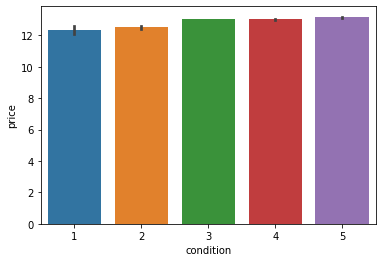

In [29]:
# condition 컬럼 확인
sns.barplot(x=df_train['condition'], y=y_train)

In [30]:
condition_group = pd.concat([df_train, y_train], axis=1).groupby('condition')

In [31]:
condition_group.mean()

,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,grade,sqft_above,...,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,new_renovated,new_long,price
condition,,,,,,,,,,,,,,,,,,,,,
1,201435.476190,1.119219,0.725763,6.870784,9.217963,1.166667,0.047619,0.428571,5.619048,6.855275,...,1931.666667,94.857143,98095.047619,47.573852,-122.269429,7.392169,8.930122,0.071429,0.249571,12.339782
2,201443.581818,1.298708,0.865042,7.155764,9.349967,1.163636,0.009091,0.090909,6.545455,7.062607,...,1950.609091,54.054545,98095.481818,47.521695,-122.233509,7.325474,9.192645,0.027273,0.285491,12.521065
3,201439.631880,1.453302,1.139533,7.581980,8.914252,1.621822,0.006127,0.210967,7.824466,7.455807,...,1979.536914,103.937711,98078.611866,47.565029,-122.202125,7.568368,8.892410,0.091034,0.316875,13.054858
4,201437.927958,1.452050,1.037451,7.499760,9.177100,1.265672,0.008595,0.272497,7.402679,7.304028,...,1958.365268,47.668099,98073.197674,47.547789,-122.229585,7.507103,9.129414,0.026163,0.289415,13.018126
5,201431.032035,1.473308,1.079115,7.531571,8.989477,1.282684,0.009524,0.310823,7.299567,7.272910,...,1945.857143,39.430303,98087.698701,47.571961,-122.254228,7.469163,8.958076,0.018182,0.264772,13.156831


> 위에서 condition을 토대로 한 데이터를 보면...
> - grade 컬럼에서는 condition 3이 사실 condition 4, 5보다 더 높은 평균을 갖고 있다.
> - price 평균에서는 condition 3이 condition 5보다는 좀 떨어지지만, condition 4보다는 높은 평균 가격을 갖고 있다.
> - 이렇게 condition과 grade는 어찌 보면 집의 상태를 제일 직관적으로 나타내주는 척도인데 이것이 price와 비례하지 않는다면,
> - 아마도 다른 요소들이 집의 가격에 좀 더 영향을 크게 끼치는 듯 하다.

In [32]:
# total_rooms 컬럼 생성
df_train['total_rooms'] = df_train['bedrooms'] + df_train['bathrooms']
df_train.head()

,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,...,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,new_renovated,new_long,total_rooms
0,201410,1.386294,0.693147,7.074117,8.639588,1.0,0,0,3,7,...,1955,0,98178,47.5112,-122.257,7.201171,8.639588,0.0,0.262,2.079442
1,201502,1.098612,0.693147,6.647688,9.210440,1.0,0,0,3,6,...,1933,0,98028,47.7379,-122.233,7.908755,8.995041,0.0,0.286,1.791759
2,201502,1.386294,1.098612,7.427144,8.997271,1.0,0,0,3,8,...,1987,0,98074,47.6168,-122.045,7.496097,8.923191,0.0,0.474,2.484907
3,201406,1.386294,1.178655,7.447751,8.827615,2.0,0,0,3,7,...,1995,0,98003,47.3097,-122.327,7.713785,8.827615,0.0,0.192,2.564949
4,201501,1.386294,0.916291,6.966967,9.181118,1.0,0,0,3,7,...,1963,0,98198,47.4095,-122.315,7.409136,9.181118,0.0,0.204,2.302585


In [33]:
# total_sqft 컬럼 생성
df_train['total_sqft'] = df_train['sqft_above'] + df_train['sqft_basement']
df_train.head()

,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,...,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,new_renovated,new_long,total_rooms,total_sqft
0,201410,1.386294,0.693147,7.074117,8.639588,1.0,0,0,3,7,...,0,98178,47.5112,-122.257,7.201171,8.639588,0.0,0.262,2.079442,7.074117
1,201502,1.098612,0.693147,6.647688,9.210440,1.0,0,0,3,6,...,0,98028,47.7379,-122.233,7.908755,8.995041,0.0,0.286,1.791759,6.647688
2,201502,1.386294,1.098612,7.427144,8.997271,1.0,0,0,3,8,...,0,98074,47.6168,-122.045,7.496097,8.923191,0.0,0.474,2.484907,7.427144
3,201406,1.386294,1.178655,7.447751,8.827615,2.0,0,0,3,7,...,0,98003,47.3097,-122.327,7.713785,8.827615,0.0,0.192,2.564949,7.447751
4,201501,1.386294,0.916291,6.966967,9.181118,1.0,0,0,3,7,...,0,98198,47.4095,-122.315,7.409136,9.181118,0.0,0.204,2.302585,6.966967


In [34]:
# 지상에서 주거공간의 비율을 나타내는 컬럼 생성
# 재건축 후인 최근 주거공간을 나타내는 sqft_living15을 사용
df_train['liv15_per_above'] = df_train['sqft_living15'] / df_train['sqft_above']
df_train.head()


,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,...,zipcode,lat,long,sqft_living15,sqft_lot15,new_renovated,new_long,total_rooms,total_sqft,liv15_per_above
0,201410,1.386294,0.693147,7.074117,8.639588,1.0,0,0,3,7,...,98178,47.5112,-122.257,7.201171,8.639588,0.0,0.262,2.079442,7.074117,1.017960
1,201502,1.098612,0.693147,6.647688,9.210440,1.0,0,0,3,6,...,98028,47.7379,-122.233,7.908755,8.995041,0.0,0.286,1.791759,6.647688,1.189700
2,201502,1.386294,1.098612,7.427144,8.997271,1.0,0,0,3,8,...,98074,47.6168,-122.045,7.496097,8.923191,0.0,0.474,2.484907,7.427144,1.009284
3,201406,1.386294,1.178655,7.447751,8.827615,2.0,0,0,3,7,...,98003,47.3097,-122.327,7.713785,8.827615,0.0,0.192,2.564949,7.447751,1.035720
4,201501,1.386294,0.916291,6.966967,9.181118,1.0,0,0,3,7,...,98198,47.4095,-122.315,7.409136,9.181118,0.0,0.204,2.302585,6.966967,1.063467


In [35]:
df_train[['sqft_above', 'sqft_living15']]

,sqft_above,sqft_living15
0,7.074117,7.201171
1,6.647688,7.908755
2,7.427144,7.496097
3,7.447751,7.713785
4,6.966967,7.409136
...,...,...
15030,7.832411,7.832411
15031,7.863651,7.626083
15032,7.333676,7.333676
15033,7.745436,7.512618


In [36]:
# 계산이 이상해서 그냥 drop
df_train.drop(columns='liv15_per_above', axis=1, inplace=True)
df_train.head()

,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,...,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,new_renovated,new_long,total_rooms,total_sqft
0,201410,1.386294,0.693147,7.074117,8.639588,1.0,0,0,3,7,...,0,98178,47.5112,-122.257,7.201171,8.639588,0.0,0.262,2.079442,7.074117
1,201502,1.098612,0.693147,6.647688,9.210440,1.0,0,0,3,6,...,0,98028,47.7379,-122.233,7.908755,8.995041,0.0,0.286,1.791759,6.647688
2,201502,1.386294,1.098612,7.427144,8.997271,1.0,0,0,3,8,...,0,98074,47.6168,-122.045,7.496097,8.923191,0.0,0.474,2.484907,7.427144
3,201406,1.386294,1.178655,7.447751,8.827615,2.0,0,0,3,7,...,0,98003,47.3097,-122.327,7.713785,8.827615,0.0,0.192,2.564949,7.447751
4,201501,1.386294,0.916291,6.966967,9.181118,1.0,0,0,3,7,...,0,98198,47.4095,-122.315,7.409136,9.181118,0.0,0.204,2.302585,6.966967


In [37]:
# test 데이터에도 동일하게 적용
df_test['total_rooms'] = df_test['bedrooms'] + df_test['bathrooms']
df_test['total_sqft'] = df_test['sqft_above'] + df_test['sqft_basement']
df_test.head()

,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,...,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,new_renovated,new_long,total_rooms,total_sqft
0,201412,1.386294,1.178655,7.852050,8.887791,2.0,0,0,3,7,...,1991,98125,47.7210,-122.319,7.433075,8.941153,1.5,0.193,2.564949,13.676905
1,201412,1.609438,1.386294,7.581210,8.517393,1.0,0,0,5,7,...,0,98136,47.5208,-122.393,7.215975,8.517393,0.0,0.119,2.995732,13.772040
2,201405,1.609438,1.704748,8.598036,11.532051,1.0,0,0,3,11,...,0,98053,47.6561,-122.005,8.468213,11.532051,0.0,0.507,3.314186,15.600098
3,201504,1.386294,0.693147,7.484930,8.918784,1.0,0,0,3,7,...,0,98146,47.5123,-122.337,7.484930,9.001346,0.0,0.175,2.079442,13.551911
4,201503,1.386294,1.252763,7.544861,8.788898,2.0,0,0,3,7,...,0,98038,47.3684,-122.031,7.779467,8.932080,0.0,0.481,2.639057,7.544861


> zipcode는 실제 세계에서는 집값을 판별하는 데 매우 중요한 요소이나, geospatial하게 하기에는 아직 어려워서 삭제하기로 했음

In [38]:
# 사용 안하는 컬럼들 지우기
df_train.drop(columns=['yr_renovated', 'zipcode', 'long'], axis=1, inplace=True)
df_test.drop(columns=['yr_renovated', 'zipcode', 'long'], axis=1, inplace=True)

print(df_train.columns)
print(df_test.columns)

Index(['date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'lat', 'sqft_living15', 'sqft_lot15',
       'new_renovated', 'new_long', 'total_rooms', 'total_sqft'],
      dtype='object')
Index(['date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'lat', 'sqft_living15', 'sqft_lot15',
       'new_renovated', 'new_long', 'total_rooms', 'total_sqft'],
      dtype='object')


### 알고리즘 선택
- 오늘 학습시간에 썼던 4가지 모델을 써보려 한다.
- GradientBoostingRegressor
- xgboost
- lightgbm
- RandomForestRegressor

#### # 먼저 모델들의 디폴트(베이스라인) RMSE를 구해보자


In [39]:
# 모델 묶어두기
# random_state 고정하기
random_state=2020

gboost = GradientBoostingRegressor(random_state=random_state)
xgboost = XGBRegressor(random_state=random_state)
lightgbm = LGBMRegressor(random_state=random_state)
rdforest = RandomForestRegressor(random_state=random_state)

models = [gboost, xgboost, lightgbm, rdforest]


In [40]:
# rmse 함수 정의
def rmse(y_test, y_pred):
    return np.sqrt(mean_squared_error(np.expm1(y_test), np.expm1(y_pred))) # 계산 전에 np.expm1()한 것 주의

In [41]:
# get_scores 코드로 스코어 확인
def get_scores(models, train, y):
    # 답안 작성
    df = {}
    
    for model in models:
        model_name = model.__class__.__name__
        
        X_train, X_test, y_train, y_test = train_test_split(train, y, random_state=random_state, test_size=0.2)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        
        df[model_name] = rmse(y_test, y_pred)
        score_df = pd.DataFrame(df, index=['RMSE']).T.sort_values('RMSE', ascending=False)
            
    return score_df

In [42]:
get_scores(models, df_train, y_train)

,RMSE
GradientBoostingRegressor,130827.014010
RandomForestRegressor,125694.223787
XGBRegressor,113686.378669
LGBMRegressor,111729.321996


> 어찌 된 게 베이스라인 보다 점수들이 더 안 좋아졌다...  
> 하이퍼파라미터 튜닝으로 점수를 더 좋게 만들 수 있는지 확인해보자

## # 하이퍼파라미터 튜닝

#### # LGBMRegressor 튜닝
- 기본적으로 제공되는 인터넷 블로그에서 모델 성능에 더 큰 영향을 미친다는 파라미터들을 두고 진행 예정이다.

In [43]:
def my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5):
    grid_model = GridSearchCV(model, param_grid=param_grid,
                scoring='neg_mean_squared_error',
                verbose=verbose,
                n_jobs=n_jobs)
    
    # 학습
    grid_model.fit(train, y)
    
    # score 뽑아내기
    params = grid_model.cv_results_['params']
    score = grid_model.cv_results_['mean_test_score']
    
    # df 만들기
    results = pd.DataFrame(params)
    results['n_mse'] = score
    results['RMSLE'] = np.sqrt(results['n_mse'] * -1)
    results = results.sort_values(by='RMSLE')
    
    return results

In [44]:
lgbm_params = {"max_depth":[100, 150, 200, 250, 300],
          "learning_rate":[0.001, 0.01, 0.1],
          'num_leaves': [6,8,12,16]
         }

# 모델 생성
lgbm = LGBMRegressor(random_state=random_state)

# GridSearch 불러오기
from sklearn.model_selection import GridSearchCV

In [45]:
# lgbm 하이퍼파라미터 확인하기
my_GridSearch(lgbm, df_train, y_train, param_grid=lgbm_params)

Fitting 5 folds for each of 60 candidates, totalling 300 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  31 tasks      | elapsed:    2.9s
[Parallel(n_jobs=5)]: Done 152 tasks      | elapsed:   10.3s
[Parallel(n_jobs=5)]: Done 300 out of 300 | elapsed:   18.9s finished


,learning_rate,max_depth,num_leaves,n_mse,RMSLE
59,0.100,300,16,-0.028219,0.167986
47,0.100,150,16,-0.028219,0.167986
51,0.100,200,16,-0.028219,0.167986
43,0.100,100,16,-0.028219,0.167986
55,0.100,250,16,-0.028219,0.167986
54,0.100,250,12,-0.029126,0.170662
58,0.100,300,12,-0.029126,0.170662
42,0.100,100,12,-0.029126,0.170662
50,0.100,200,12,-0.029126,0.170662
46,0.100,150,12,-0.029126,0.170662


In [46]:
# 제일 좋게 나온 파라미터를 넣고 확인해보기

lgbm = LGBMRegressor(max_depth=300, learning_rate=0.1, num_leaves=16)

sec_X_train, sec_X_test, sec_y_train, sec_y_test = train_test_split(df_train,
                                                                   y_train,
                                                                   test_size=0.2,
                                                                    random_state=random_state)
lgbm.fit(sec_X_train, sec_y_train)

# overfitting, underfitting 확인
print(lgbm.score(sec_X_train, sec_y_train))
print(lgbm.score(sec_X_test, sec_y_test))

# rmse 확인
y_pred = lgbm.predict(sec_X_test)
rmse_value = rmse(sec_y_test, y_pred)
print(rmse_value)

0.918875133320903
0.9009297082585631
111281.03186493744


> 여전히 RMSE가 낮다...  
> 사실 4가지 모델 중 가장 성능이 좋게 나왔어서 여기서 확실히 RMSE 값이 110000 밑으로 떨어지는 걸 확인해야 한다고 생각한다.  
> 하이퍼파라미터 튜닝을 다시 해보자.

In [47]:
# 확실히 learning_rate 은 0.1이 좋은 것 같고
# num_leaves 는 더 많아도 되는지 확인해봐야겠다.
# max_depth도 그냥 -1 값도 넣어보자
param_grid = {"max_depth":[300, 400, -1],
              'num_leaves':[32,48,64]}

# 모델 생성
lgbm = LGBMRegressor(random_state=random_state)

results = my_GridSearch(lgbm, df_train, y_train, param_grid=param_grid)
results

Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  31 tasks      | elapsed:    3.7s
[Parallel(n_jobs=5)]: Done  45 out of  45 | elapsed:    5.2s finished


,max_depth,num_leaves,n_mse,RMSLE
1,300,48,-0.026926,0.164091
4,400,48,-0.026926,0.164091
7,-1,48,-0.026926,0.164091
2,300,64,-0.026959,0.164191
5,400,64,-0.026959,0.164191
8,-1,64,-0.026959,0.164191
0,300,32,-0.027149,0.164769
3,400,32,-0.027149,0.164769
6,-1,32,-0.027149,0.164769


In [48]:
# 제일 좋게 나온 파라미터를 넣고 확인해보기

lgbm = LGBMRegressor(max_depth=300, num_leaves=48)

sec_X_train, sec_X_test, sec_y_train, sec_y_test = train_test_split(df_train,
                                                                   y_train,
                                                                   test_size=0.2,
                                                                    random_state=random_state)
lgbm.fit(sec_X_train, sec_y_train)

# overfitting, underfitting 확인
print(lgbm.score(sec_X_train, sec_y_train))
print(lgbm.score(sec_X_test, sec_y_test))

# rmse 확인
y_pred = lgbm.predict(sec_X_test)
rmse_value = rmse(sec_y_test, y_pred)
print(rmse_value)

0.9468944076735449
0.9051389086963307
112827.1224512318


In [49]:
# 이쯤 가니 overfitting이 나는 것 같아서
# lambda 관련 파라미터를 넣어보자
# 손을 댈수록 rmse가 더 낮아진다....
param_grid = {"max_depth":[300, 400, -1],
              'num_leaves':[32,48,64],
             'reg_alpha':[1, 1.5, 2, 2.5]}

# 모델 생성
lgbm = LGBMRegressor(random_state=random_state)

results = my_GridSearch(lgbm, df_train, y_train, param_grid=param_grid)
results

Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  31 tasks      | elapsed:    3.7s
[Parallel(n_jobs=5)]: Done 152 tasks      | elapsed:   18.0s
[Parallel(n_jobs=5)]: Done 180 out of 180 | elapsed:   21.7s finished


,max_depth,num_leaves,reg_alpha,n_mse,RMSLE
32,-1,64,1.0,-0.026893,0.163991
20,400,64,1.0,-0.026893,0.163991
8,300,64,1.0,-0.026893,0.163991
28,-1,48,1.0,-0.026905,0.164027
4,300,48,1.0,-0.026905,0.164027
16,400,48,1.0,-0.026905,0.164027
22,400,64,2.0,-0.026920,0.164072
34,-1,64,2.0,-0.026920,0.164072
10,300,64,2.0,-0.026920,0.164072
0,300,32,1.0,-0.026932,0.164111


In [50]:
# 제일 좋게 나온 파라미터를 넣고 확인해보기

lgbm = LGBMRegressor(max_depth=-1, num_leaves=64, reg_alpha=1.0)

sec_X_train, sec_X_test, sec_y_train, sec_y_test = train_test_split(df_train,
                                                                   y_train,
                                                                   test_size=0.2,
                                                                    random_state=random_state)
lgbm.fit(sec_X_train, sec_y_train)

# overfitting, underfitting 확인
print(lgbm.score(sec_X_train, sec_y_train))
print(lgbm.score(sec_X_test, sec_y_test))

# rmse 확인
y_pred = lgbm.predict(sec_X_test)
rmse_value = rmse(sec_y_test, y_pred)
print(rmse_value)

0.949346215517814
0.9069428936788502
108699.3914767754


In [51]:
# 아직 overfitting 같으니 한 번 더 다른 방법으로 접근해보자
# L1 규제 관련된 파라미터를 넣었으니, num_leaves를 좀 더 늘려봐야겠다.
# 그리고 규제 값을 좀 더 세분화해보자
param_grid = {"max_depth":[300, 500, 100],
              'num_leaves':[64,86,128],
             'reg_alpha':[1, 1.2, 1.4, 1.6]}

# 모델 생성
lgbm = LGBMRegressor(random_state=random_state)

results = my_GridSearch(lgbm, df_train, y_train, param_grid=param_grid)
results

Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  31 tasks      | elapsed:    5.1s
[Parallel(n_jobs=5)]: Done 152 tasks      | elapsed:   25.5s
[Parallel(n_jobs=5)]: Done 180 out of 180 | elapsed:   30.8s finished


,max_depth,num_leaves,reg_alpha,n_mse,RMSLE
1,300,64,1.2,-0.026760,0.163586
13,500,64,1.2,-0.026760,0.163586
25,100,64,1.2,-0.026760,0.163586
0,300,64,1.0,-0.026893,0.163991
12,500,64,1.0,-0.026893,0.163991
24,100,64,1.0,-0.026893,0.163991
2,300,64,1.4,-0.026932,0.164110
14,500,64,1.4,-0.026932,0.164110
26,100,64,1.4,-0.026932,0.164110
18,500,86,1.4,-0.027007,0.164338


In [52]:
# 제일 좋게 나온 파라미터를 넣고 확인해보기

lgbm = LGBMRegressor(max_depth=300, num_leaves=64, reg_alpha=1.2)

sec_X_train, sec_X_test, sec_y_train, sec_y_test = train_test_split(df_train,
                                                                   y_train,
                                                                   test_size=0.2,
                                                                    random_state=random_state)
lgbm.fit(sec_X_train, sec_y_train)

# overfitting, underfitting 확인
print(lgbm.score(sec_X_train, sec_y_train))
print(lgbm.score(sec_X_test, sec_y_test))

# rmse 확인
y_pred = lgbm.predict(sec_X_test)
rmse_value = rmse(sec_y_test, y_pred)
print(rmse_value)

0.9479101996883051
0.9045210619313024
111705.95818479707


In [53]:
# 다시 위의 110000 미만 RMSE 나오는지 해당 모델로 다시 확인

lgbm = LGBMRegressor(max_depth=-1, num_leaves=64, reg_alpha=1.0)

sec_X_train, sec_X_test, sec_y_train, sec_y_test = train_test_split(df_train,
                                                                   y_train,
                                                                   test_size=0.2,
                                                                    random_state=random_state)
lgbm.fit(sec_X_train, sec_y_train)

# overfitting, underfitting 확인
print(lgbm.score(sec_X_train, sec_y_train))
print(lgbm.score(sec_X_test, sec_y_test))

# rmse 확인
y_pred = lgbm.predict(sec_X_test)
rmse_value = rmse(sec_y_test, y_pred)
print(rmse_value)

0.949346215517814
0.9069428936788502
108699.3914767754


> 아직 overfitting 같긴 한데 일단 해당 모델로 진짜 submission 했을 때 값이 어떤지 제출해보자

In [54]:
# submit 함수 정의
def submit(model, X_test, RMSLE=None):
    y_pred = model.predict(X_test)
    y_pred = np.expm1(y_pred) # exp 변환
    
    # bring submission file
    path = os.getenv("HOME") + '/aiffel/kaggle_kakr_housing/data'
    submission_path = os.path.join(path, 'submission.csv')
    submission = pd.read_csv(submission_path)
    submission['price'] = y_pred
    
    model_name = model.__class__.__name__
    save_path = os.path.join(path, f'submission_{model_name}_RMSLE_{RMSLE}.csv')
    submission.to_csv(save_path, index=False)

In [55]:
submit(lgbm, df_test, RMSLE=rmse_value)

> private score : **116725.46786** 가 나왔다.  
> validation으로 해볼 때 10만 밑으로 가면 확실히 11만 이하로 떨어질 것 같으니 그렇게 진행해보자.

## # 개선해보기

### 1) Scaler로 다 scaling 해보기
- 그냥 궁금하다. 한 번 해보자

In [56]:
from sklearn.preprocessing import StandardScaler

ss = StandardScaler()

In [57]:
ss.fit(df_train)

StandardScaler()

In [58]:
df_train_ss = ss.transform(df_train)
df_test_ss = ss.transform(df_test)

In [59]:
# 다시 위에 썼던 LGBMRegressor 모델로 확인

lgbm = LGBMRegressor(max_depth=-1, num_leaves=64, reg_alpha=1.0)

ss_X_train, ss_X_test, _y_train, _y_test = train_test_split(df_train_ss,
                                                                   y_train,
                                                                   test_size=0.2,
                                                                    random_state=random_state)
lgbm.fit(ss_X_train, _y_train)

# overfitting, underfitting 확인
print(lgbm.score(ss_X_train, _y_train))
print(lgbm.score(ss_X_test, _y_test))

# rmse 확인
y_pred = lgbm.predict(ss_X_test)
rmse_value = rmse(_y_test, y_pred)
print(rmse_value)

0.94915460988369
0.9037051888204194
113486.11055709637


In [60]:
# 다시 위에 썼던 LGBMRegressor 모델로 확인
# reg_alpha 더 줘봤다.(1.0 -> 2.0)

lgbm = LGBMRegressor(max_depth=-1, num_leaves=64, reg_alpha=2.0)

ss_X_train, ss_X_test, _y_train, _y_test = train_test_split(df_train_ss,
                                                                   y_train,
                                                                   test_size=0.2,
                                                                    random_state=random_state)
lgbm.fit(ss_X_train, _y_train)

# overfitting, underfitting 확인
print(lgbm.score(ss_X_train, _y_train))
print(lgbm.score(ss_X_test, _y_test))

# rmse 확인
y_pred = lgbm.predict(ss_X_test)
rmse_value = rmse(_y_test, y_pred)
print(rmse_value)

0.9430386897187726
0.9049411526802512
109886.64932708735


In [61]:
# 다시 위에 썼던 LGBMRegressor 모델로 확인
# reg_alpha 더 줘봤다.(2.0 -> 3.0)

lgbm = LGBMRegressor(max_depth=-1, num_leaves=64, reg_alpha=3.0)

ss_X_train, ss_X_test, _y_train, _y_test = train_test_split(df_train_ss,
                                                                   y_train,
                                                                   test_size=0.2,
                                                                    random_state=random_state)
lgbm.fit(ss_X_train, _y_train)

# overfitting, underfitting 확인
print(lgbm.score(ss_X_train, _y_train))
print(lgbm.score(ss_X_test, _y_test))

# rmse 확인
y_pred = lgbm.predict(ss_X_test)
rmse_value = rmse(_y_test, y_pred)
print(rmse_value)

0.9377930934334158
0.9037368365488753
109542.10585288405


In [62]:
# 윗 모델도 실제 제출 시 RMSE 확인
submit(lgbm, df_test, RMSLE=rmse_value)

In [63]:
pd.DataFrame(df_train_ss, columns=df_train.columns).describe()

,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,lat,sqft_living15,sqft_lot15,new_renovated,new_long,total_rooms,total_sqft
count,1.503500e+04,1.503500e+04,1.503500e+04,1.503500e+04,1.503500e+04,1.503500e+04,1.503500e+04,1.503500e+04,1.503500e+04,1.503500e+04,1.503500e+04,1.503500e+04,1.503500e+04,1.503500e+04,1.503500e+04,1.503500e+04,1.503500e+04,15035.000000,1.503500e+04,1.503500e+04
mean,5.127439e-14,7.618190e-16,9.451849e-16,1.557665e-15,1.255206e-15,5.293035e-17,8.034072e-18,-3.402666e-17,1.890370e-16,-2.230636e-16,-2.533095e-15,-3.780740e-18,3.810985e-15,1.697198e-15,3.761836e-16,7.410249e-16,3.969777e-17,0.000000,-1.107757e-15,-7.561479e-17
std,1.000033e+00,1.000033e+00,1.000033e+00,1.000033e+00,1.000033e+00,1.000033e+00,1.000033e+00,1.000033e+00,1.000033e+00,1.000033e+00,1.000033e+00,1.000033e+00,1.000033e+00,1.000033e+00,1.000033e+00,1.000033e+00,1.000033e+00,1.000033,1.000033e+00,1.000033e+00
min,-7.580916e-01,-6.893141e+00,-4.405677e+00,-4.414602e+00,-3.021768e+00,-9.249168e-01,-8.466250e-02,-3.068752e-01,-3.722682e+00,-5.645812e+00,-4.017121e+00,-7.963813e-01,-2.417836e+00,-2.930094e+00,-4.718056e+00,-3.050763e+00,-1.932114e-01,-2.160971,-6.309085e+00,-1.364387e+00
25%,-7.128945e-01,-3.160588e-01,-3.740122e-01,-6.724742e-01,-5.188089e-01,-9.249168e-01,-8.466250e-02,-3.068752e-01,-6.290205e-01,-5.600485e-01,-7.349505e-01,-7.963813e-01,-6.835339e-01,-6.370937e-01,-7.160141e-01,-5.222299e-01,-1.932114e-01,-0.809140,-6.307532e-01,-8.226541e-01
50%,-6.450988e-01,-3.160588e-01,2.917702e-01,7.095385e-03,-5.977202e-02,3.581837e-03,-8.466250e-02,-3.068752e-01,-6.290205e-01,-5.600485e-01,-8.998922e-02,-7.963813e-01,1.326084e-01,8.091642e-02,-5.816446e-02,-3.037762e-02,-1.932114e-01,-0.122607,1.545754e-01,-6.461763e-01
75%,1.433970e+00,7.426150e-01,5.871224e-01,6.949301e-01,3.145015e-01,9.320805e-01,-8.466250e-02,-3.068752e-01,9.178102e-01,2.875787e-01,7.268998e-01,1.196799e+00,8.807389e-01,8.510401e-01,6.820543e-01,3.145956e-01,-1.932114e-01,0.620546,7.492974e-01,1.140103e+00
max,1.501766e+00,4.483342e+00,4.351208e+00,4.607433e+00,5.878154e+00,3.717576e+00,1.181161e+01,4.933180e+00,2.464641e+00,4.525715e+00,4.079418e+00,1.832970e+00,1.492846e+00,1.569774e+00,3.624070e+00,5.796113e+00,6.923235e+00,6.360522,4.646795e+00,2.427609e+00


> 이런 방법은 효과가 없나보다...  
> 캐글에 제출하니 **1476018.91860**점이 나왔다.  
> Scaler는 어떨 때 효과가 있을까...?  
> 음... 찾아 보니 regression이고, sample-wise말고 feature-wise로 데이터가 relation이 있으면 쓰면 좋다는데....  
> 일단 이번에는 어떤 이유에서인지 잘 안 됐다.

### 2) Polynomial Features 한 번 써보자
- 여기서 한번 내가 전처리한 데이터 vs 원래 데이터로 내가 전처리한 데이터의 효과(?)를 봐보자

In [64]:
# 내가 전처리한 데이터 사용

from sklearn.preprocessing import PolynomialFeatures

poly = PolynomialFeatures(include_bias=False)
poly.fit(df_train) # 내가 전처리한 데이터를 써봤다.
train_poly = poly.transform(df_train)
test_poly = poly.transform(df_test)

ss = StandardScaler()
ss.fit(train_poly)
train_poly_ss = ss.transform(train_poly)
test_poly_ss = ss.transform(test_poly)

print(f'train_poly_ss.shape: {train_poly_ss.shape}')
print(f'test_poly_ss.shape: {test_poly_ss.shape}')

poly_X_train, poly_X_val, poly_y_train, poly_y_val = train_test_split(train_poly_ss,
                                                                     y_train,
                                                                     test_size=0.2,
                                                                     random_state=random_state)

from sklearn.linear_model import Ridge
ridge = Ridge(alpha=0.001, max_iter=10000)
ridge.fit(poly_X_train, poly_y_train)
y_pred = ridge.predict(poly_X_val)
print(f'ridge score for train set : {ridge.score(poly_X_train, poly_y_train)}')
print(f'ridge score for val set : {ridge.score(poly_X_val, poly_y_val)}')
print(f'rmse : {rmse(poly_y_val, y_pred)}')

train_poly_ss.shape: (15035, 230)
test_poly_ss.shape: (6468, 230)
ridge score for train set : 0.8259039469976334
ridge score for val set : 0.8219659097705352
rmse : 152046.66734376756


In [65]:
# 원본 데이터 사용

from sklearn.preprocessing import PolynomialFeatures

poly = PolynomialFeatures(include_bias=False)
poly.fit(df_train_original) # 원본 데이터 사용
train_poly = poly.transform(df_train_original)
test_poly = poly.transform(df_test_original)

ss = StandardScaler()
ss.fit(train_poly)
train_poly_ss = ss.transform(train_poly)
test_poly_ss = ss.transform(test_poly)

print(f'train_poly_ss.shape: {train_poly_ss.shape}')
print(f'test_poly_ss.shape: {test_poly_ss.shape}')

poly_X_train, poly_X_val, poly_y_train, poly_y_val = train_test_split(train_poly_ss,
                                                                     y_train,
                                                                     test_size=0.2,
                                                                     random_state=random_state)

from sklearn.linear_model import Ridge
ridge = Ridge(alpha=0.001, max_iter=10000)
ridge.fit(poly_X_train, poly_y_train)
y_pred = ridge.predict(poly_X_val)
print(f'ridge score for train set : {ridge.score(poly_X_train, poly_y_train)}')
print(f'ridge score for val set : {ridge.score(poly_X_val, poly_y_val)}')
print(f'rmse : {rmse(poly_y_val, y_pred)}')

train_poly_ss.shape: (15035, 209)
test_poly_ss.shape: (6468, 209)
ridge score for train set : 0.8363872779806867
ridge score for val set : 0.8319766796850845
rmse : 146067.2952904775


> 이런... 나의 데이터 전처리가 별로였다.........

### 3) 약한 나무 여러 개가 강하다고 했으니까, Averaging Blending으로 예측해보자
> 일단 EDA는 둘째치고 블렌딩으로 극복할 수 있는지 확인해보자  
> 그래도 나의 전처리 데이터를 갖고 할 수 있는지 확인....

In [66]:
# 4개의 모델
gboost = GradientBoostingRegressor()
xgboost = XGBRegressor()
lightgbm = LGBMRegressor(max_depth=-1, num_leaves=64, reg_alpha=1.0) # 윗 모델 사용
rdforest = RandomForestRegressor()


# 모델 집합
models = [gboost, xgboost, lightgbm, rdforest]

In [67]:
# Averaging Blending 후 sumbit 하는 함수 정의
def AveragingBlending_submit(models, x, y, sub_x, mention='avb'):
    for m in models : 
        m.fit(x.values, y)
    
    predictions = np.column_stack([m.predict(sub_x.values) for m in models])
    y_pred = np.mean(predictions, axis=1)
    y_pred = np.expm1(y_pred)
    
    # bring submission file
    path = os.getenv("HOME") + '/aiffel/kaggle_kakr_housing/data'
    submission_path = os.path.join(path, 'submission.csv')
    submission = pd.read_csv(submission_path)
    submission['price'] = y_pred
    
    save_path = os.path.join(path, f'submission_{mention}.csv')
    submission.to_csv(save_path, index=False)

In [68]:
AveragingBlending_submit(models, df_train, y_train, df_test)

> 캐글 점수 120501.91017가 나왔다......  
> 그냥 내 전처리 데이터로는 어떻게 할 수 없나 보다....  

In [69]:
AveragingBlending_submit(models, df_train_original, y_train, df_test_original, mention='original_used')

> 캐글 점수 118064.66220가 나왔다...  
> 역시 내가 심혈(?)을 기울인 전처리는 예측을 오히려 방해했다.

> _**결국 캐글 점수 11만 이하는 달성하지 못했다...**_  
> 정답풀이를 찾아보는 겸 캐글에 제출된 코드들을 보면서 공부해야겠다...

## # 회고

#### Point 1) EDA
- 시간을 정말 많이 빼았겼다.
- yr_renovated 컬럼에서 다중 조건으로 불린인덱싱 후 해당 값들만 쏙쏙 다른 값으로 바꾸는 것에 2~3시간 정도 헤맸다...
  - 헤맨 점을 살짝 요약하자면, apply 함수를 쓰면 쏙쏙 해당 값들만 바뀔 줄 알았는데 series 전체를 다 꺼내서 바꾸는 것이라 앞서 특정 조건의 행 값을 바꾼 것들이 다 NaN 값이 되었다...
  - 또 year로 쓰인 것 중에 float 형태가 있었는데, 이걸 바꾸는 방법을 찾다가 시간이 많이 쓰였다..
    - `df_train['yr_renovated'].copy().astype(str).apply(lambda x: x[:4]).astype(int)` 이렇게 하면 년도 4자리만 뜰 줄 알았는데 안되었다... 왜 그런지 나도 궁금하다
- outlier 같은 걸 보는 것도 있는데 시간 여건상 못해봤다.(언젠간 많이 익숙해져서 이것저것 해볼 수 있기를...)

#### Point 2) Input contains NaN, infinity or a value too large for dtype('float64').
- 이것을 해결하기 위해 또 노력 많이 했다..
- 보니까 y 값을 log 변환을 안 했었다.
- 그리고 np.expm1()에 넣으려 하니까 inf 값이 되어버려서 오류가 났었다...
- 이것을 나름 debugging 한 경험은 꽤 값진 것 같다.(함수의 부분 부분마다 실행하면서 어디서 오류가 나는지 확인했다)
  - get_score() 함수에서 오류가 나길래
  - model.predict()까지 오류가 있나 봤는데 없었다.
  - rmse() 함수에서 오류가 나길래
  - 제일 안쪽인 np.expm1()에 y_pred 값을 넣으니 inf... 값만 있는 시리즈가 나왔다
  
#### Point 3) 로그 변환을 테스트 데이터셋에 적용하지 않음...
- 사실 끝까지 몰랐다.
- RMSE가 11만 이하가 나와서 캐글에 제출해보니 50만이 나왔다.
- 이상하길래 베이스라인의 price와 내가 제출한 price를 보니 차이가 엄청 났다.
- 그래서 train, test 셋의 describe()를 통해 보니까 test셋은 로그 변환이 안 되어 있던 걸 나중에야 알았다.
- 그런데 그 때 가서 로그 변환을 하자니 이미 전처리된 데이터들에도 영향이 가서 해당 부분은 그냥 삭제하고 앞단에 로그 변환 코드를 추가했다.
- 어떤 데이터들은 스케일링이 안되어도 예측값에 별 차이가 없다고 했었는데, 이번 데이터는 컬럼별 값 차이가 커서 그런지 예측값에 어마어마한 차이가 났었다.

#### Point 4) 랜덤서치
- 엄청 느리다.
- xgbregressor를 랜덤서치로 하이퍼파라미터 튜닝해본다고 캐글 같은 곳에 나와 있는 코드를 비슷하게 해봤는데 파라미터 수를 엄청 줄여도 도저히 속도가 나질 않았다.
- 그래서 그냥 접었는데, 도대체 언제 쓸만한 녀석인지 궁금하다.

#### Point 5) 결국 내 EDA는 안 좋은 전처리였다...(EDA의 역할을 진정으로 깨달음)
- 일단 Point 1에서 쓴 EDA가 내가 주력(?)으로 실험한 것이었는데, 요약하면 년도로 되어 있는 yr_renovated를 점수 같이 바꾸는 것이었다.
- 왜냐하면 여튼 renovated 됐으면 더 좋아진 건데 년도로 되어 있어서 해당 컬럼의 스케일 차이가 꽤 나니까(안 한 건 0, 한 건 2000년대까지 있음) 점수 같이 바꾸면 좋을 거라고 생각했다.
- 하지만 뒤돌아 보니 한 가지 놓친 점을 생각해냈다.
- 바로 이 컬럼들은 다른 컬럼들과 유기적으로 연결되어 있는 실제 데이터라는 것...
- renovated 되면 분명 좋은 거였어서 0보다 큰 1자리대 양수를 준다는 게 좋은 생각 같았지만,
- 한편으로는 renovated 안됐어도 최근에 지어진 거면 옛날에 renovated 된 것보다 더 시설이 좋았을 것이다.
- 즉 renovated이 점수가 0인 것들 중에 renovated 점수가 1 ~ 1.5인 것(2000년 전에 renovated 된 것)보다 더 최근에 지어진 건물이 있을 거란 것이다.
- 이를 통해 데이터를 좀 더 차분히 살피고, 깊숙하게 바라볼 수 있도록 EDA에 더 많은 시간을 쏟아야겠다는 생각을 하게 되었다.